# Liability Driven Investing (LDI)

The aim with LDI is to build 2 portfolios:<br> 
1- A Performance Seeking Portfolio (PSP): This is focused on diversification and to generate positive returns<br>
2- A Liability Hedging Portfolio (LHP): One which hedges impact of risk in liabilities

This strategy is usually used by pension funds or companies which have a large amount of liabilities due in the future, and somehow need to cover them. Zero Coupon Bonds (ZCBS) are an effective way to hedge liabilities since they are immune to changes in interest rates, and will give us the desired return in the future to cover our liabilities. However, we need to have enough assets in the present time to be able to generate the desired amount with the ZCB to cover the future liabilities. 

If we invest in cash (treasury bills or money market funds) to hedge liabilities, there is uncertainty due to changes in interest rates, so there is a possibility that we would be underfunded when our liabilities are due. Hence, it would be a good strategy to invest in a mix of long and short coupon bearing bonds to hedge the liabilities.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## $ dr_t = a(b - r_t)dt + \sigma\sqrt{r_t}dW_t $

$dr_t$ = change in interest rates <br>
b = long-term interest rate mean<br>
$r_t$= interest rate at time t<br>
$\sigma$ is volatility of interest rate<br>
dt is afixed time interval<br>
$dW_t$ follows a normal distribution with mean $\mu$ and variance = dt<br>
a = mean reversion rate i.e how fast do interest rates revert to the long-term interest rate

In [112]:
# Lets model interest rates using the above Cox-IngersolL-Ross model. These can be then used to price ZCBs 
def cir(num_years, num_scenarios, a, b, sigma, periods_per_year, r_0):
    num_periods = num_years * periods_per_year
    dt = 1/periods_per_year
    shock = np.random.normal(0, scale = np.sqrt(dt), size = (num_periods, num_scenarios))
    rates = np.zeros_like(shock)
    rates[0] = r_0
    for period in range(1, num_periods):
        r_t = rates[period - 1]
        dr_t = a*(b - r_t)*dt + sigma*np.sqrt(r_t)*shock[period]
        rates[period] = abs(r_t + dr_t)
    return pd.DataFrame(data = rates, index = range(num_periods))

cir(5, 5, 0.05, 0.03, 0.05, 1, 0.01)

,0,1,2,3,4
0,0.010000,0.010000,0.010000,0.010000,0.010000
1,0.007664,0.015582,0.019616,0.016682,0.012706
2,0.009317,0.019005,0.016858,0.012309,0.013386
3,0.006880,0.011949,0.016671,0.007914,0.014497
4,0.003303,0.018258,0.024344,0.013162,0.025096


In [113]:
# Discount factor and present value formulas 
def discount(t, r):
    return (1+r) ** (-t)

def present_value(flows, r):
    dates = flows.index
    discounts = discount(dates, r)
    return (discounts * flows).sum()

In [114]:
# Bond cash flows
def bond_cf(maturity, principal, coupon_rate, coupons_per_period):
    num_coupons = maturity * coupons_per_period
    coupon_payments = principal * coupon_rate/coupons_per_period
    coupon_dates = np.arange(1, num_coupons + 1)
    cash_flows = pd.Series(index = coupon_dates, data = coupon_payments)
    cash_flows.iloc[-1] = cash_flows.iloc[-1] + principal
    return cash_flows

In [115]:
# Bond price
def bond_price(maturity, principal, coupon_rate, coupons_per_period, discount_rate):
    cash_flows = bond_cf(maturity, principal, coupon_rate, coupons_per_period)
    return present_value(cash_flows, discount_rate/ coupons_per_period)

bond_price(5, 100, 0.1, 1, 0.01)

143.68088115392607

Text(0, 0.5, 'Bond Price')

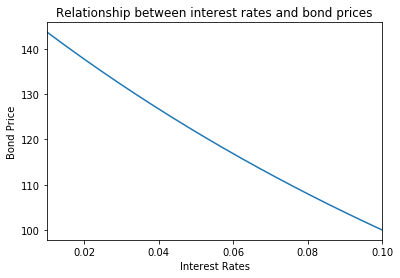

In [123]:
# We see that with an increase in interest rates, the bond price decreases
int_rates = np.linspace(0.01, 0.1, num = 20)
prices = [bond_price(5, 100, 0.1, 1, rate) for rate in int_rates]
pd.DataFrame(data = prices, index = int_rates).plot(legend = False, title = "Relationship between interest rates and bond prices")
plt.xlabel("Interest Rates")
plt.ylabel("Bond Price")

In [124]:
# The Macaulay duration is the weighted average term to maturity of the cash flows from a bond. It is frequently used by portfolio managers who use an immunization strategy.
def macaulay_dur(flows, discount_rate):
    dcf = discount(flows.index, discount_rate) * flows
    weights = dcf/dcf.sum()
    return (flows.index * weights).sum()

def match_dur(cf_t, cf_s, cf_l, discount_rate):
    t_d = macaulay_dur(cf_t, discount_rate)
    s_d = macaulay_dur(cf_s, discount_rate)
    l_d = macaulay_dur(cf_l, discount_rate)
    return (l_d - t_d)/(l_d - s_d) 

In [130]:
# Lets say we have liabilities of 100K due in 10 and 12 years time respectively
# We have assets worth 160K right now which we can invest in the long and short bond to hedge our liabilities
liabilities = pd.Series(data = [100000, 100000], index =[10, 12])
a_0 = 160000

# We will use a combination of a short and long bond to hedge our liabilities
short_bond = bond_cf(10, 1000, 0.05, 1)
long_bond = bond_cf(20, 1000, 0.05, 1)
w_s = match_dur(liabilities, short_bond, long_bond, 0.04)
w_s # We will allocate this amount to the short bond

0.4826309206947901

In [134]:
price_short = bond_price(10, 1000, 0.05, 1, 0.02)
price_long = bond_price(20, 1000, 0.05, 1, 0.02)

p_flows = pd.concat([a_0 * w_s * short_bond/ price_short,
                    a_0 * (1 - w_s) * long_bond/ price_long])
sb_assets = a_0 * short_bond/ price_short
lb_assets = a_0 * long_bond/ price_long

In [135]:
def funding_ratio(assets, liabilities, r):
    return present_value(assets, r)/ present_value(liabilities, r)

Text(0, 0.5, 'Funding Ratio')

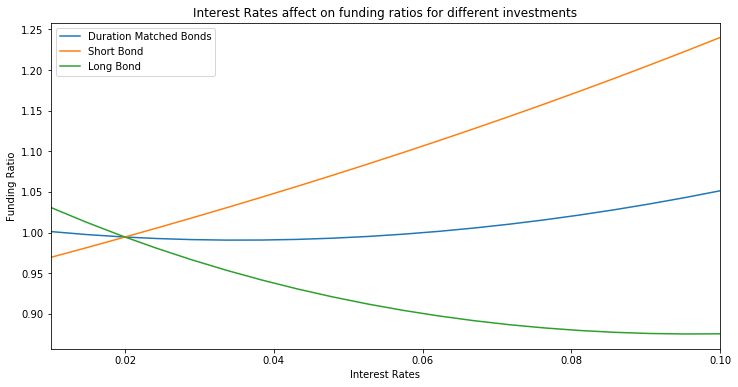

In [136]:
immunization = pd.DataFrame({
    "Duration Matched Bonds": [funding_ratio(p_flows, liabilities, r) for r in int_rates],
    "Short Bond": [funding_ratio(sb_assets, liabilities, r) for r in int_rates],
    "Long Bond": [funding_ratio(lb_assets, liabilities, r) for r in int_rates]
}, index = int_rates)
immunization.plot(title = "Interest Rates affect on funding ratios for different investments", figsize = (12,6))
plt.xlabel("Interest Rates")
plt.ylabel("Funding Ratio")

A funding ratio of 1 means our assets equal our liabilities. Funding ratio = $\frac{assets}{liabilities}$<br>
If we had invested solely in the long bond, our funding ratio would have dropped as interest rates increased.<br>
The opposite would have been true if we invested solely in short bonds.<br>
This graph shows us that by investing in both the short and long bond, our funding ratio stays close to 1 throughout the interest rate changes<br>
This process is immunization: when the portfolio is immune to changes in interest rates

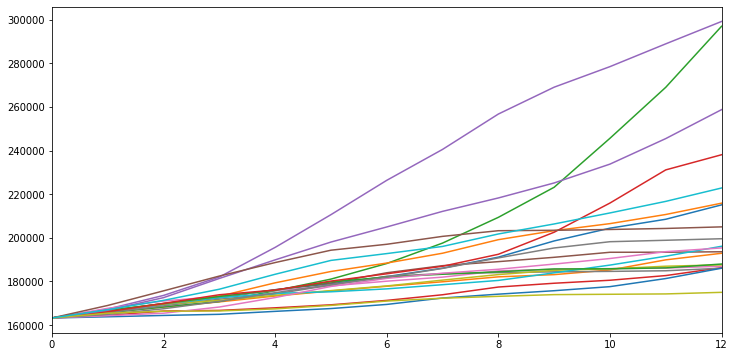

In [137]:
# investing in the cash account comes with uncertainty as we see different possible future simulations below. We might be funded to cover our liabilities in 10 and 12 years time, or we might not. SO it is better to invest in zcb or coupon bearing bonds.
rates = cir(13, 20, 0.05, 0.03, 0.05, 1, 0.02)
rates.head()
av_cash = a_0 * (rates + 1).cumprod()
av_cash.plot(legend=False, figsize = (12,6))